In [1]:
import matplotlib.pyplot as plt
import pde
import numpy as np
import torch
import pandas as pd
from torch.nn import functional as F


from numpy import pi
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

plt.rcParams['figure.figsize'] = [10, 10]

In [2]:
def solveEquationPYPDE(variable, eq, ic="2/cosh(x)**2", xrange=None, yrange=None, points=150, trange=0.4):
    #initialize xrange
    if xrange is None:
        xrange = [-pi, pi]
    
    #eq is passed in as a string with x as the dependent variable
    eq = pde.PDE({variable: eq})
    
    if yrange is not None:
        grid = pde.grids.CartesianGrid([xrange, yrange], [points], periodic=[True, True])
    else:
        grid = pde.grids.CartesianGrid([xrange], [points],  periodic=True)
    
    field = pde.ScalarField.from_expression(grid, ic)

    storage = pde.MemoryStorage()
    trackers = ['progress', storage.tracker(interval=0.001)]
    #bc = ["periodic", {'derivative': 'periodic'}]
    #field /= np.sqrt(field.to_scalar('norm_squared').integral.real)

    solver = pde.ExplicitSolver(eq, backend='numba' ,scheme='runge-kutta', adaptive=True, tolerance=1e-9)
    controller = pde.Controller(solver, t_range=trange, tracker=trackers)
    solution = controller.run(field, dt=1e-4)
    
    return field, storage

In [3]:
s1, st1 = solveEquationPYPDE('phi', f"- phi * d_dx(phi) - 0.025*laplace(d_dx(phi))")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 0.4/0.4 [00:19<00:00, 49.34s/it]


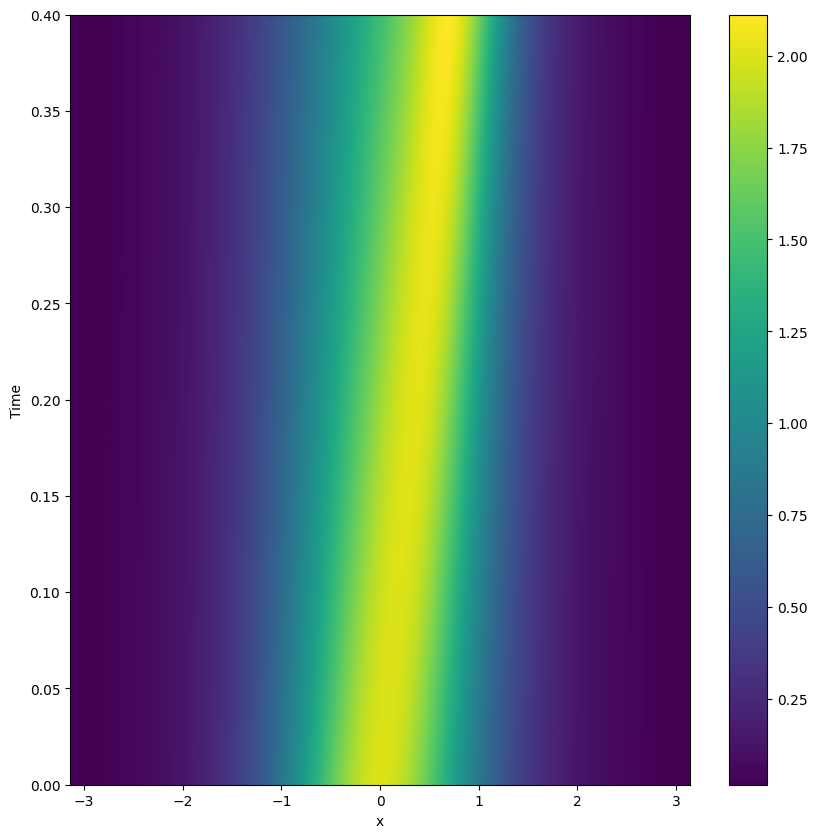

In [4]:
pde.plot_kymograph(st1)

In [5]:
x = s1.get_line_data()['data_x'].reshape(-1,1) # X x 1
t = np.array(st1.times).reshape(-1,1) # T x 1
x_grid, t_grid = np.meshgrid(x, t)


phi = np.array(st1.data)
#u = np.real(phi) #.flatten().reshape(-1,1)[::10].reshape(79,30)   #.flatten()[:,None]
#v = np.imag(phi) #.flatten().reshape(-1,1)[::10].reshape(79,30)  #.flatten()[:,None]

#plt.pcolormesh(x_grid, t_grid, np.sqrt(u**2 + v**2))

##Generate the two indices
idx1 = np.random.choice(x_grid.shape[0], 105, replace=False)
idx1 = np.sort(idx1)
idx2 = np.random.choice(x_grid.shape[1], 100, replace=False)
idx2 = np.sort(idx2)

def gen_train(grid):
    grid_new = grid[idx1]
    grid_new = grid_new[:,idx2]
    return grid_new
    
x_train, t_train, phi_train = gen_train(x_grid), gen_train(t_grid), gen_train(phi)

## attempt to plot
##plt.pcolormesh(x_train, t_train, phi_train)

In [6]:
## reshape to feed into model
x_train = x_train.flatten()[:,None]
t_train = t_train.flatten()[:,None]

phi_train = phi_train.flatten()[:,None]
print(x_train.shape, t_train.shape, phi_train.shape)

(10500, 1) (10500, 1) (10500, 1)


In [7]:
## boilerplate stuff for GPU...
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

## create gridmesh for plotting
x_axis = torch.linspace(-pi, 2*pi, 100, dtype=torch.float16)
t_axis = torch.linspace(0, 0.5, 100, dtype=torch.float16)

x_grid, t_grid = torch.meshgrid(x_axis, t_axis, indexing='xy')
xt_pairs = torch.stack((x_grid, t_grid), dim=2)
xt_pairs = xt_pairs.reshape(xt_pairs.shape[0] * xt_pairs.shape[1],2).to(device)

class PINN():
    def __init__(self, x, t, phi, dDim=256, nHid=4):
        self.x = torch.tensor(x, dtype=torch.float16, requires_grad=True, device=device)
        self.t = torch.tensor(t, dtype=torch.float16, requires_grad=True, device=device)
        
        self.phi = torch.tensor(phi, dtype=torch.float16, device=device)
        
        self.null = torch.zeros((self.x.shape[0],1), dtype=torch.float16, device=device)
        self.dDim = dDim
        self.nHid = nHid
        self.net_init()
        #self.optim = torch.optim.LBFGS(self.net.parameters(),
        #                               lr=0.01,
        #                               max_iter=50000,
        #                               max_eval=50000,
        #                               history_size=50,
        #                               tolerance_grad=1e-8,
        #                               tolerance_change=0.5 * np.finfo(float).eps,
        #                               line_search_fn='strong_wolfe'
        #                              )

        self.optim = torch.optim.Adam(self.net.parameters(), lr=1e-4)
        
        self.mse = torch.nn.MSELoss()
        self.ls = 0
        self.step = 0
    
    def net_init(self, act=torch.nn.Tanh):
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, self.dDim), act(),
            torch.nn.Sequential(*[
                torch.nn.Sequential(*[
                    torch.nn.Linear(self.dDim, self.dDim), act()
            ]) for _ in range(self.nHid)]),
            torch.nn.Linear(self.dDim, 1)
        )
        self.net.to(device)

        for module in self.net.modules():
            if isinstance(module, act):
                module = torch.cuda.amp.autocast()(module)
    
    def func(self, x, t):
        with torch.cuda.amp.autocast():
            phi = self.net(torch.hstack((x, t)))
    
            phi_t = torch.autograd.grad(phi, t, torch.ones_like(phi), create_graph=True)[0]
            phi_x = torch.autograd.grad(phi, x, torch.ones_like(phi), create_graph=True)[0]
            phi_xx = torch.autograd.grad(phi_x, x, torch.ones_like(phi_x), create_graph=True)[0]
            phi_xxx = torch.autograd.grad(phi_xx, x, torch.ones_like(phi_xx), create_graph=True)[0]
    
            f_phi = phi_t + 6 * phi * phi_x + phi_xxx
        return phi, f_phi
        
    def closure(self):
        self.optim.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast():
            phi_pred, f_phi_pred = self.func(self.x, self.t)
            phi_loss = self.mse(phi_pred, self.phi)
            f_phi_loss = self.mse(f_phi_pred, self.null)
            self.ls = phi_loss + f_phi_loss
        self.ls.backward()
        
        if not self.step % 100:
            print(f"Step: {self.step}, Loss: {self.ls}")
            pred = self.net(xt_pairs.float()).reshape((100,100)).detach().cpu()
            plt.pcolormesh(x_grid.numpy(), t_grid.numpy(), pred.numpy())
            plt.colorbar()
            plt.show()
        self.step += 1
        return self.ls

    def train(self):
        self.net.train()
        for i in range(500):
            self.optim.step(self.closure)

In [8]:
kdv = PINN(x_train, t_train, phi_train)

/home/gallirium/dostNN/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Step: 0, Loss: 0.8336578011512756


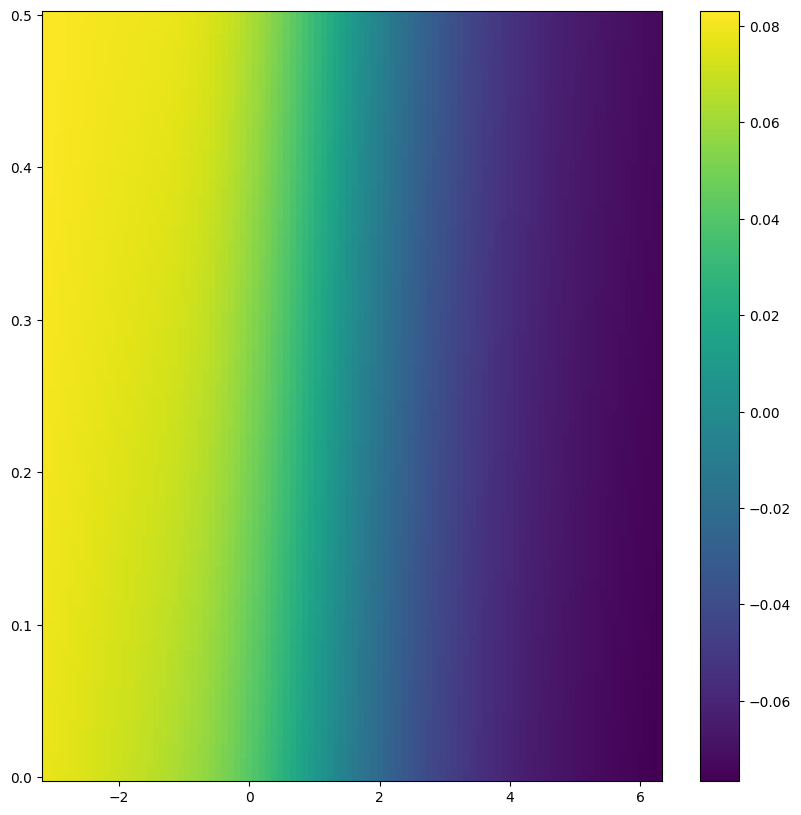

/home/gallirium/dostNN/lib/python3.11/site-packages/torch/autograd/__init__.py:251: UserWarning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [10500, 1], strides() = [1, 0]
param.sizes() = [10500, 1], strides() = [1, 0] (Triggered internally at ../torch/csrc/autograd/functions/accumulate_grad.h:219.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step: 100, Loss: 0.19866055250167847


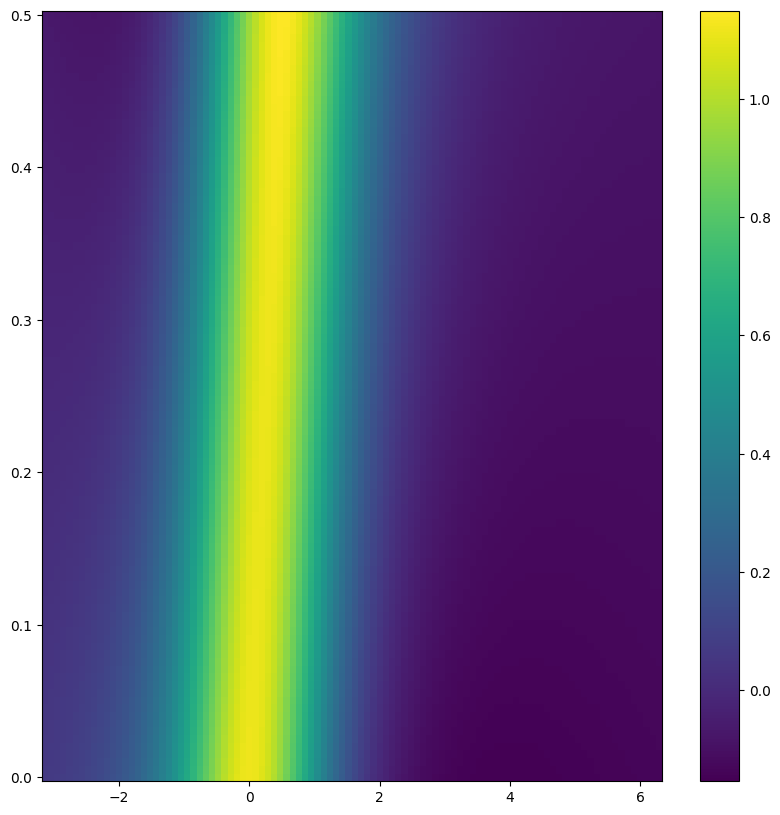

Step: 200, Loss: 0.12536931037902832


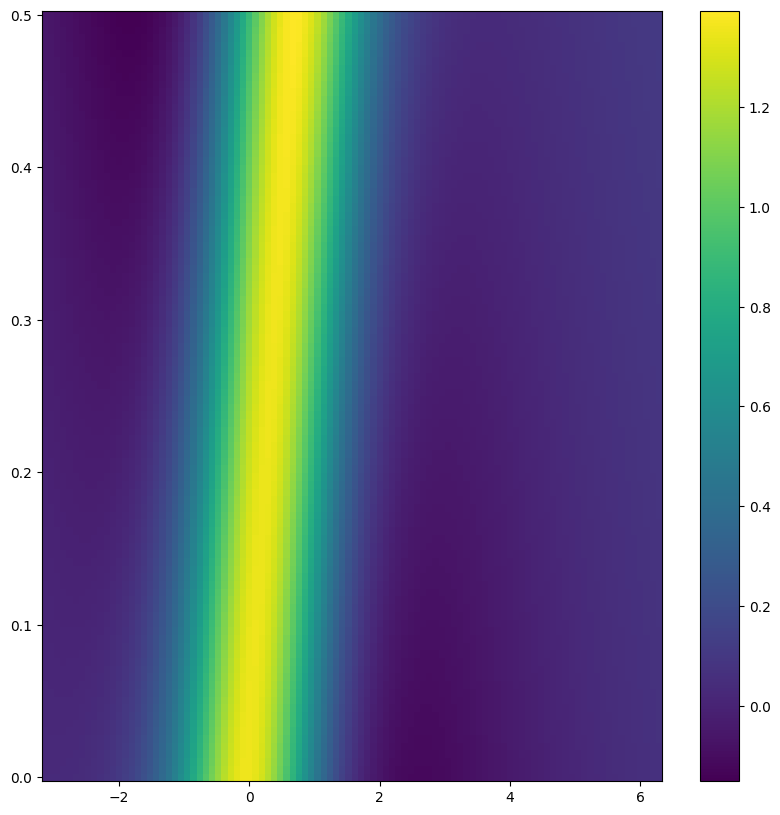

Step: 300, Loss: 0.07654158771038055


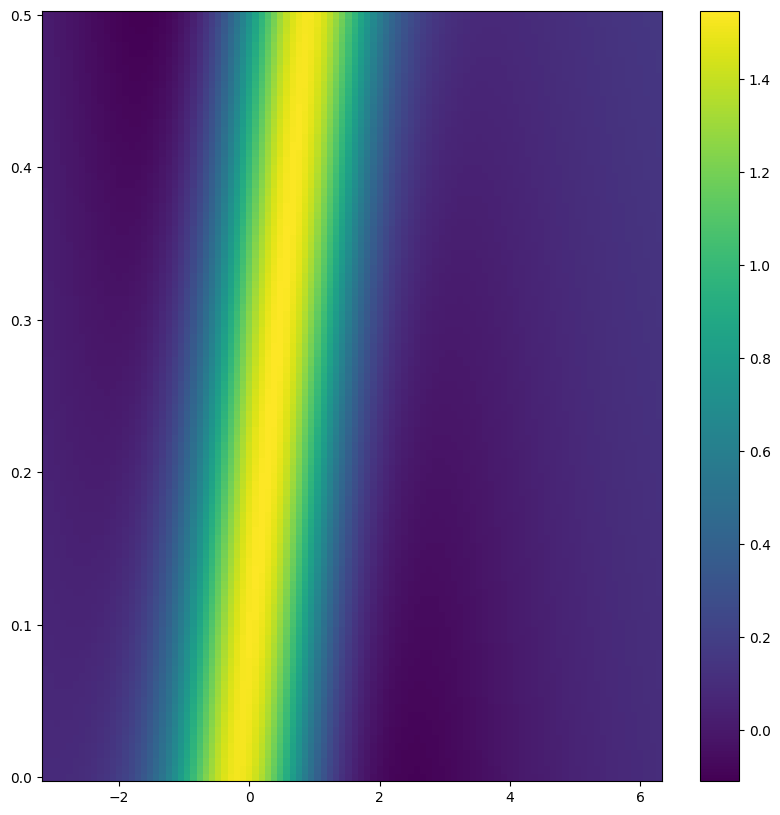

Step: 400, Loss: 0.06786315888166428


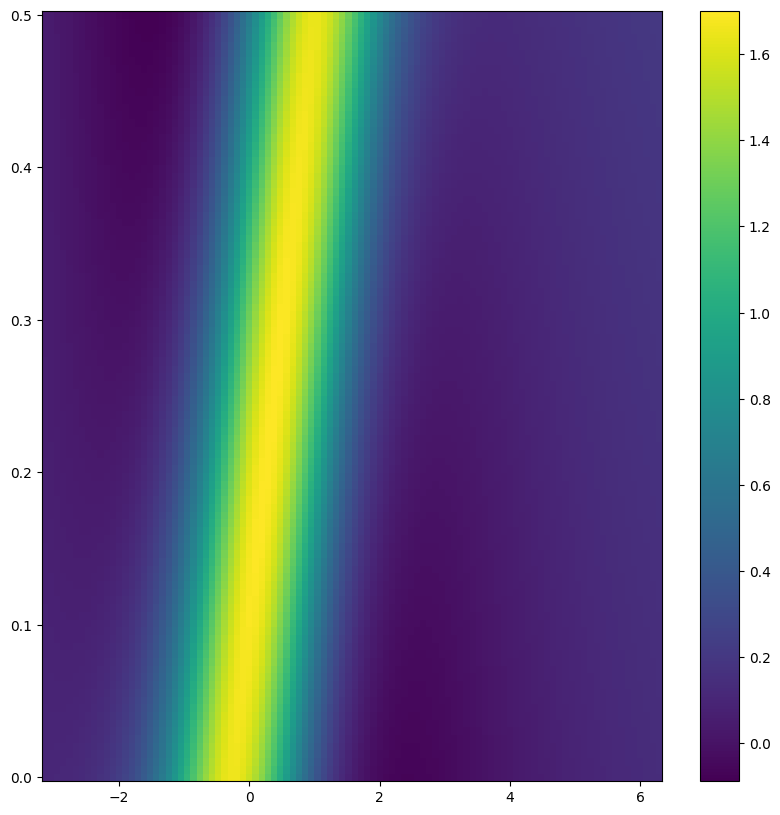

CPU times: user 9.97 s, sys: 13.8 s, total: 23.8 s
Wall time: 22.1 s


In [9]:
%%time
kdv.train()

## fp32 precision (500 epochs) took 57.5 s
## fp16 precision (500 epochs) took 28.6 s

In [10]:
x_axis = torch.linspace(-pi, pi, 100)
t_axis = torch.linspace(0, 0.5, 100)

x_grid, t_grid = torch.meshgrid(x_axis, t_axis, indexing='xy')
xt_pairs = torch.stack((x_grid, t_grid), dim=2)
xt_pairs = xt_pairs.reshape(xt_pairs.shape[0] * xt_pairs.shape[1],2).to(device)

phi = kdv.net(xt_pairs).reshape((100,100)).detach().cpu()

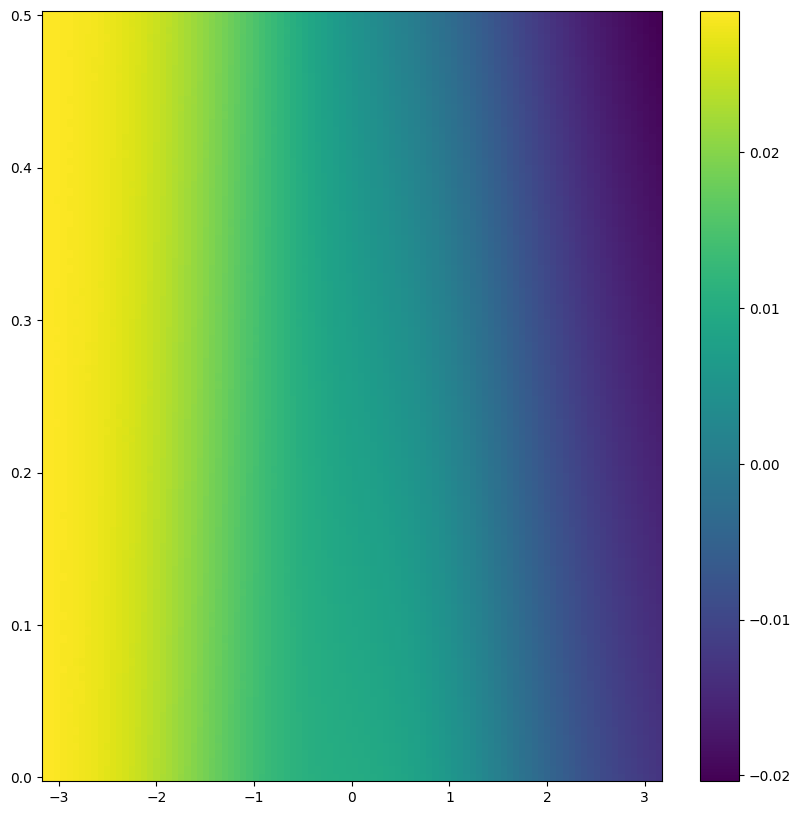

In [11]:
plt.pcolormesh(x_grid, t_grid, phi)
plt.colorbar()
plt.show()

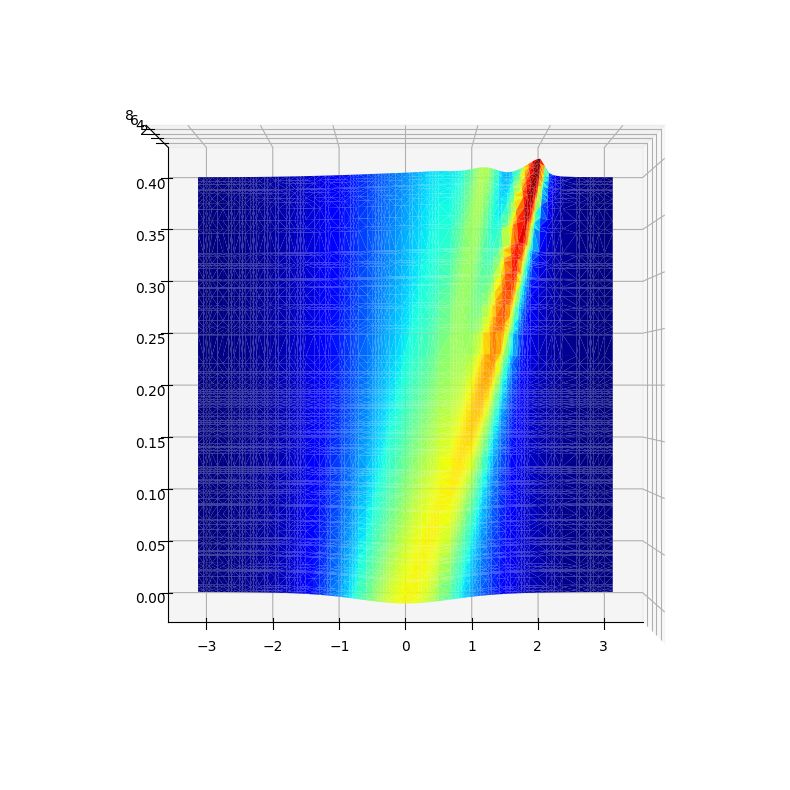

In [74]:
## CHECK IF THE TRAINING DATA IS ALIGNED

xx = x_train.flatten()
tt = t_train.flatten()
z = phi_train.flatten()

ax = plt.axes(projection='3d')
ax.view_init(90, -90, 0)
ax.plot_trisurf(xx, tt, z, cmap='jet')

In [84]:
kdv.ls

tensor(0.2318, device='cuda:0', grad_fn=<AddBackward0>)

In [89]:
import pandas as pd

In [114]:
df = pd.DataFrame(columns=[2,4,6,8,10])
for n_layers in [2,4,6,8,10]:
    print('%%%%%%%%%%%%%%%')
    print(str(n_layers))
    print('%%%%%%%%%%%%%%%')
    tmp = []
    for dim in [32,64,128,256]:
        print('########' + str(dim) + '##########')
        model = PINN(x_train, t_train, phi_train, dDim=dim, nHid=n_layers)
        model.train()
        tmp.append(model.ls.item())
    df[n_layers] = pd.Series(tmp)

df

%%%%%%%%%%%%%%%
2
%%%%%%%%%%%%%%%
########32##########
Step: 0, Loss: 1.1754759550094604
########64##########
Step: 0, Loss: 0.9479941725730896
########128##########
Step: 0, Loss: 1.0193003416061401
########256##########
Step: 0, Loss: 0.9688273072242737
%%%%%%%%%%%%%%%
4
%%%%%%%%%%%%%%%
########32##########
Step: 0, Loss: 0.9617257118225098
########64##########
Step: 0, Loss: 1.0804765224456787
########128##########
Step: 0, Loss: 0.9122313261032104
########256##########
Step: 0, Loss: 1.0572781562805176
%%%%%%%%%%%%%%%
6
%%%%%%%%%%%%%%%
########32##########
Step: 0, Loss: 1.0959197282791138
########64##########
Step: 0, Loss: 1.1498162746429443
########128##########
Step: 0, Loss: 0.9820396900177002
########256##########
Step: 0, Loss: 0.9939364194869995
%%%%%%%%%%%%%%%
8
%%%%%%%%%%%%%%%
########32##########
Step: 0, Loss: 1.349025011062622
########64##########
Step: 0, Loss: 0.8270384669303894
########128##########
Step: 0, Loss: 1.0006083250045776
########256##########
Step: 0, Lo

,2,4,6,8,10
0,0.323778,0.341427,0.350345,0.363182,0.190223
1,0.259222,0.130139,0.095833,0.101812,0.084680
2,0.110085,0.057806,0.065868,0.066505,0.081783
3,0.061154,0.054562,0.057465,0.059197,0.060900


In [102]:
kdv.ls.item()

0.23178139328956604

In [8]:
torch.linspace(-pi, 2*pi, 100).dtype

torch.float32

In [55]:
lst = torch.nn.Sequential(*[torch.nn.Sequential(*[torch.nn.Linear(10, 10), torch.nn.Tanh()]) for _ in range(3)])
lst

Sequential(
  (0): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Tanh()
  )
  (1): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Tanh()
  )
  (2): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Tanh()
  )
)

[Sequential(
   (0): Linear(in_features=10, out_features=10, bias=True)
   (1): Tanh()
 ),
 Sequential(
   (0): Linear(in_features=10, out_features=10, bias=True)
   (1): Tanh()
 ),
 Sequential(
   (0): Linear(in_features=10, out_features=10, bias=True)
   (1): Tanh()
 ),
 Sequential(
   (0): Linear(in_features=10, out_features=10, bias=True)
   (1): Tanh()
 ),
 Sequential(
   (0): Linear(in_features=10, out_features=10, bias=True)
   (1): Tanh()
 )]

In [24]:
kdv.net

Sequential(
  (0): Linear(in_features=2, out_features=256, bias=True)
  (1): Tanh()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): Tanh()
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): Tanh()
  (6): Linear(in_features=256, out_features=256, bias=True)
  (7): Tanh()
  (8): Linear(in_features=256, out_features=256, bias=True)
  (9): Tanh()
  (10): Linear(in_features=256, out_features=256, bias=True)
  (11): Tanh()
  (12): Linear(in_features=256, out_features=1, bias=True)
)